In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/precog-assignment/fi.csv
/kaggle/input/precog-assignment/fi-2.csv
/kaggle/input/precog-assignment/judge_act_pre-2.csv
/kaggle/input/precog-assignment/final.csv
/kaggle/input/precog-assignment/state_time.png
/kaggle/input/precog-assignment/state_cases.png
/kaggle/input/precog-assignment/Judge_Act_merge.csv
/kaggle/input/precog-assignment/judges_clean/judges_clean.csv
/kaggle/input/precog-assignment/acts_sections/acts_sections.csv
/kaggle/input/precog-assignment/cases/cases_2015.csv
/kaggle/input/precog-assignment/cases/cases_2012.csv
/kaggle/input/precog-assignment/cases/cases_2018.csv
/kaggle/input/precog-assignment/cases/cases_2013.csv
/kaggle/input/precog-assignment/cases/cases_2017.csv
/kaggle/input/precog-assignment/cases/cases_2010.csv
/kaggle/input/precog-assignment/cases/cases_2014.csv
/kaggle/input/precog-assignment/cases/cases_2016.csv
/kaggle/input/precog-assignment/cases/cases_2011.csv
/kaggle/input/precog-assignment/keys/type_name_key.csv
/kaggle/input/precog-

In [74]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer

from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from yellowbrick.classifier import ROCAUC

import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
data = pd.read_csv("../input/precog-assignment/final.csv",usecols=["criminal","state_code","female_judge","female_defendant","tenure","time_taken"])
data.head()

,criminal,state_code,female_judge,female_defendant,tenure,time_taken
0,0.0,13.0,0 nonfemale,0 male,43,200
1,0.0,13.0,0 nonfemale,0 male,138,421
2,1.0,7.0,0 nonfemale,0 male,621,869
3,1.0,7.0,0 nonfemale,0 male,1000,1174
4,1.0,7.0,0 nonfemale,0 male,441,578


In [43]:
num_attributes = ["time_taken"]
cat_attributes = ["criminal","state_code","female_judge","female_defendant"]

In [44]:
data = data[(data["tenure"] > 0) & (data["time_taken"] > 0)] # removing spurious rows
for c in cat_attributes:
    data[c] = data[c].astype('category')

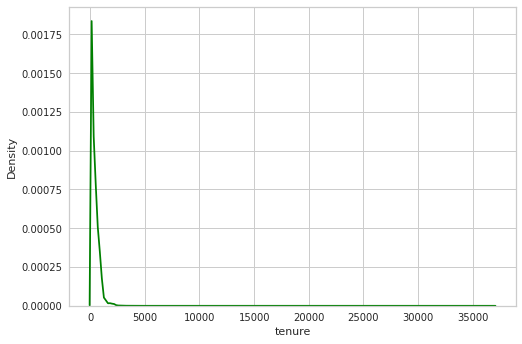

In [45]:
res = sns.kdeplot(data["tenure"],color='green')
plt.show()

In [46]:
data.describe()

,tenure,time_taken
count,3.115696e+06,3.115696e+06
mean,3.849675e+02,3.005516e+02
std,3.580247e+02,3.637689e+02
min,1.000000e+00,1.000000e+00
25%,1.230000e+02,2.600000e+01
50%,2.800000e+02,1.520000e+02
75%,5.600000e+02,4.510000e+02
max,3.702100e+04,3.652400e+04


In [47]:
(data[data["tenure"] > 2000].shape[0] * 100)/data.shape[0]

0.526142473463393

In [48]:
data = data[data["tenure"] < 2000]

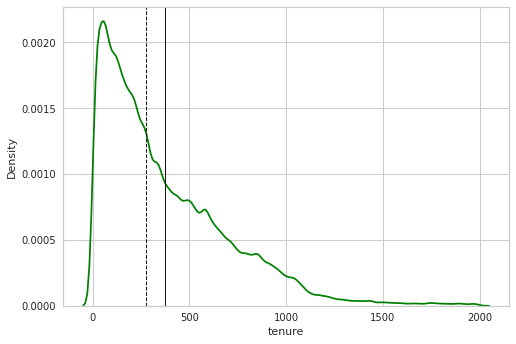

In [49]:
res = sns.kdeplot(data["tenure"],color='green')
plt.axvline(x=data.tenure.mean(), color='k',linestyle='-', linewidth=1) 
plt.axvline(x=data.tenure.median(), color='k',linestyle='--', linewidth=1) 
plt.show()

In [50]:
mean_ratio = (data[data["tenure"] > data.tenure.mean()].shape[0] * 100)/data.shape[0]
median_ratio = (data[data["tenure"] > data.tenure.median()].shape[0] * 100)/data.shape[0]

print("Percentage of instances greater than the mean: ",mean_ratio)
print("Percentage of instances greater than the median: ",median_ratio)

Percentage of instances greater than the mean:  39.514982560409386
Percentage of instances greater than the median:  49.903719262923204


In [51]:
threshold = data["tenure"].median()
print(threshold)

278.0


In [52]:
def label(tenure):
    if(tenure > threshold):
        return 1
    else:
        return 0

In [53]:
data["target"] = data.apply(lambda x:label(x["tenure"]),axis = 1)
data.head()

,criminal,state_code,female_judge,female_defendant,tenure,time_taken,target
0,0.0,13.0,0 nonfemale,0 male,43,200,0
1,0.0,13.0,0 nonfemale,0 male,138,421,0
2,1.0,7.0,0 nonfemale,0 male,621,869,1
3,1.0,7.0,0 nonfemale,0 male,1000,1174,1
4,1.0,7.0,0 nonfemale,0 male,441,578,1


In [54]:
data = data[num_attributes + cat_attributes + ["target"]]
data.head()

,time_taken,criminal,state_code,female_judge,female_defendant,target
0,200,0.0,13.0,0 nonfemale,0 male,0
1,421,0.0,13.0,0 nonfemale,0 male,0
2,869,1.0,7.0,0 nonfemale,0 male,1
3,1174,1.0,7.0,0 nonfemale,0 male,1
4,578,1.0,7.0,0 nonfemale,0 male,1


In [55]:
data['target'].value_counts()

0    1552619
1    1546651
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

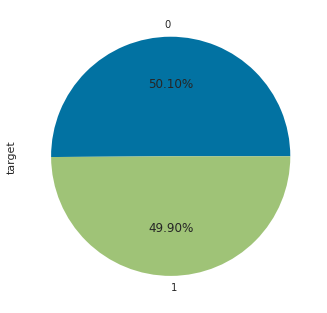

In [56]:
data['target'].value_counts().plot.pie(autopct = '%1.2f%%')

In [57]:
y = data.pop('target') #Target
X = data  #DataFrame with features

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=10)
print(y_train.value_counts())
print(y_test.value_counts())

0    1163853
1    1160599
Name: target, dtype: int64
0    388766
1    386052
Name: target, dtype: int64


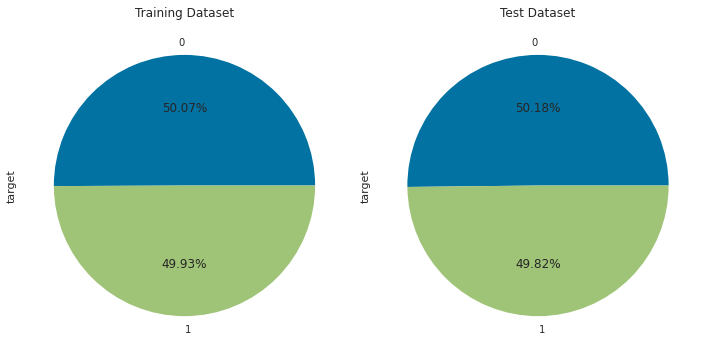

In [58]:
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
y_train.value_counts().plot.pie(autopct = '%1.2f%%')
plt.title('Training Dataset')

plt.subplot(1,2,2)
y_test.value_counts().plot.pie(autopct = '%1.2f%%')
plt.title('Test Dataset')

plt.tight_layout()

In [59]:
X_train = pd.get_dummies(X_train) ## OneHotEncoding
for c in num_attributes:
    pt = PowerTransformer()
    X_train.loc[:, c] = pt.fit_transform(np.array(X_train[c]).reshape(-1, 1))

In [60]:
X_train.head()

,time_taken,criminal_0.0,criminal_1.0,state_code_1.0,state_code_2.0,state_code_3.0,state_code_4.0,state_code_5.0,state_code_6.0,state_code_7.0,...,state_code_24.0,state_code_25.0,state_code_26.0,state_code_27.0,state_code_29.0,state_code_30.0,female_judge_0 nonfemale,female_judge_1 female,female_defendant_0 male,female_defendant_1 female
2731210,1.947131,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
273090,1.435107,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2859216,-0.270707,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2827865,0.531463,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
347485,-0.863891,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [61]:
y_train.head()

2731210    1
273090     0
2859216    1
2827865    1
347485     0
Name: target, dtype: int64

In [75]:
ovo_c = OneVsOneClassifier(SGDClassifier(random_state=42))
rf_c = RandomForestClassifier()
mlp_c = MLPClassifier(random_state=1,max_iter=500)

In [63]:
X_test = pd.get_dummies(X_test)
for c in num_attributes:
    pt = PowerTransformer()
    X_test.loc[:, c] = pt.fit_transform(np.array(X_test[c]).reshape(-1, 1))

In [64]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    visualizer = ROCAUC(model, binary=True)
                                                                         
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

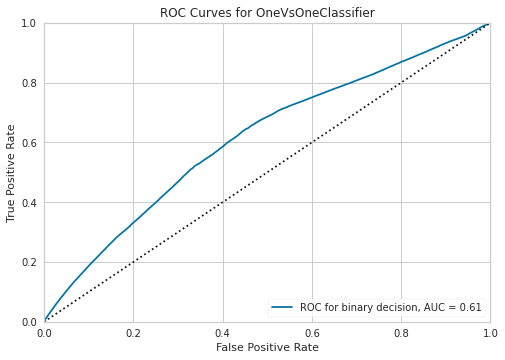

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for OneVsOneClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=True,
       estimator=OneVsOneClassifier(estimator=SGDClassifier(random_state=42)),
       macro=False, micro=False, per_class=False)

In [65]:
plot_ROC_curve(ovo_c,X_train,y_train,X_test,y_test)

In [66]:
ovo_c.fit(X_train,y_train)
pred_o = ovo_c.predict(X_test)

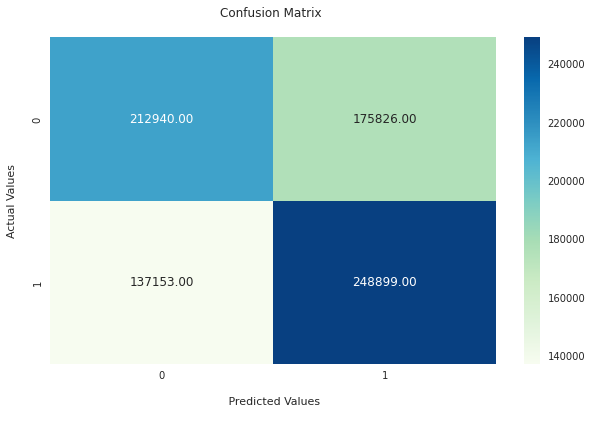

In [67]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,pred_o), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['0','1'])
fx.yaxis.set_ticklabels(['0','1'])
plt.show()

In [68]:
print(classification_report(y_test, pred_o))

              precision    recall  f1-score   support

           0       0.61      0.55      0.58    388766
           1       0.59      0.64      0.61    386052

    accuracy                           0.60    774818
   macro avg       0.60      0.60      0.60    774818
weighted avg       0.60      0.60      0.60    774818



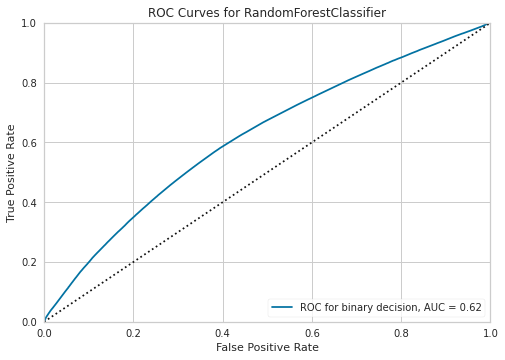

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=True, estimator=RandomForestClassifier(), macro=False,
       micro=False, per_class=False)

In [69]:
plot_ROC_curve(rf_c,X_train,y_train,X_test,y_test)

In [70]:
rf_c.fit(X_train,y_train)
pred_r = rf_c.predict(X_test)

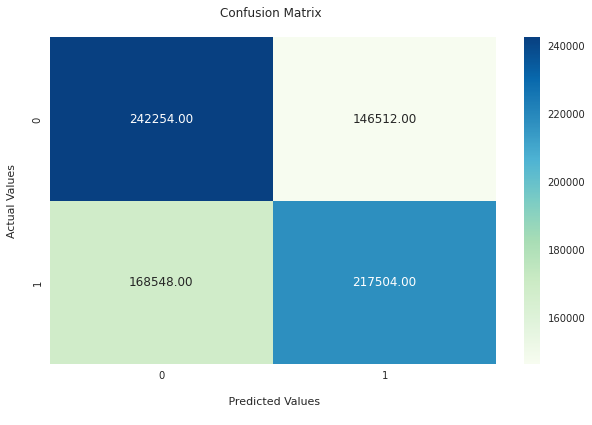

In [71]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,pred_r), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['0','1'])
fx.yaxis.set_ticklabels(['0','1'])
plt.show()

In [72]:
print(classification_report(y_test, pred_r))

              precision    recall  f1-score   support

           0       0.59      0.62      0.61    388766
           1       0.60      0.56      0.58    386052

    accuracy                           0.59    774818
   macro avg       0.59      0.59      0.59    774818
weighted avg       0.59      0.59      0.59    774818



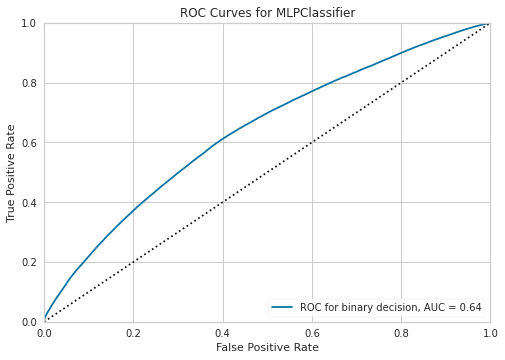

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=True, estimator=MLPClassifier(max_iter=500, random_state=1),
       macro=False, micro=False, per_class=False)

In [76]:
plot_ROC_curve(mlp_c,X_train,y_train,X_test,y_test)

In [77]:
mlp_c.fit(X_train,y_train)
pred_m = mlp_c.predict(X_test)

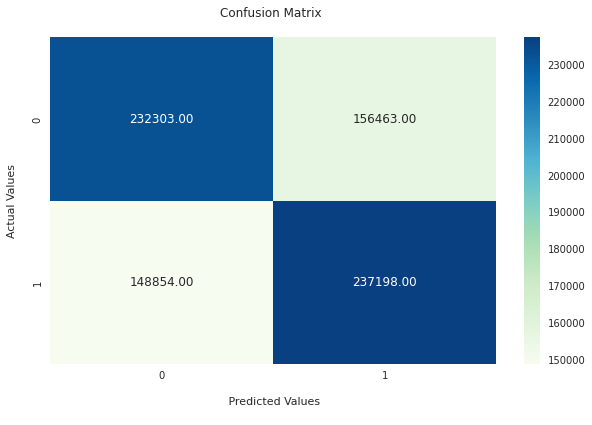

In [78]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,pred_m), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['0','1'])
fx.yaxis.set_ticklabels(['0','1'])
plt.show()

In [79]:
print(classification_report(y_test, pred_m))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60    388766
           1       0.60      0.61      0.61    386052

    accuracy                           0.61    774818
   macro avg       0.61      0.61      0.61    774818
weighted avg       0.61      0.61      0.61    774818

